In [1]:
import os
import copy
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

CONFIG = {
    "seed": 42,
    "img_size": 224,
    "batch_size": 32,
    "num_workers": 4,
    "head_epochs": 5,
    "finetune_epochs": 25,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "patience": 5,
    "label_smoothing": 0.1,
    "max_grad_norm": 1.0,
    "use_weighted_sampler": False,
    "mixup_enabled": False,
    "mixup_alpha": 0.4,
    "tta_steps": 5,
    "best_model_path": "/kaggle/working/dermnet_resnet50_best.pth",
}

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

print(f"Device: {device}")


Device: cuda


In [2]:
def discover_dataset_root(input_root: str = "/kaggle/input/datasets/shubhamgoel27/dermnet") -> Path:
    input_root = Path(input_root)
    if not input_root.exists():
        raise FileNotFoundError(f"Input directory not found: {input_root}")

    candidate_roots = []
    for ds_dir in sorted([p for p in input_root.iterdir() if p.is_dir()]):
        candidate_roots.append(ds_dir)
        for child in sorted([p for p in ds_dir.iterdir() if p.is_dir()]):
            candidate_roots.append(child)
            for grandchild in sorted([p for p in child.iterdir() if p.is_dir()]):
                candidate_roots.append(grandchild)

    generic_names = {
        "train", "training", "val", "valid", "validation", "test", "testing",
        "images", "imgs", "data", "dataset"
    }

    best = None
    for root in candidate_roots:
        class_dirs = [p for p in root.iterdir() if p.is_dir()]
        if len(class_dirs) < 2:
            continue

        class_counts = {}
        total_images = 0
        for class_dir in class_dirs:
            count = sum(
                1 for f in class_dir.rglob("*")
                if f.is_file() and f.suffix.lower() in IMG_EXTENSIONS
            )
            if count > 0:
                class_counts[class_dir.name] = count
                total_images += count

        if len(class_counts) < 2 or total_images == 0:
            continue

        generic_hits = sum(name.lower() in generic_names for name in class_counts)
        score = (len(class_counts), total_images, -generic_hits)

        if best is None or score > best[0]:
            best = (score, root)

    if best is None:
        raise RuntimeError("Could not find a valid DermNet-style class-folder dataset inside /kaggle/input")

    return best[1]


def build_dataframe_from_folder(root: Path) -> pd.DataFrame:
    records = []
    class_dirs = sorted([p for p in root.iterdir() if p.is_dir()], key=lambda x: x.name.lower())

    for class_dir in class_dirs:
        image_paths = sorted(
            [p for p in class_dir.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTENSIONS]
        )
        for image_path in image_paths:
            records.append({"image_path": str(image_path), "label": class_dir.name})

    if not records:
        raise RuntimeError(f"No images found under dataset root: {root}")

    df = pd.DataFrame(records)
    class_counts = df["label"].value_counts()
    df = df[df["label"].isin(class_counts[class_counts > 0].index)].reset_index(drop=True)

    if df["label"].nunique() < 2:
        raise RuntimeError("Need at least 2 classes for multi-class classification")

    return df


def analyze_and_plot(df: pd.DataFrame) -> dict[str, int]:
    class_counts = df["label"].value_counts().sort_values(ascending=False)

    print(f"Number of classes: {class_counts.shape[0]}")
    print("Class names:")
    print(class_counts.index.tolist())
    print("Class distribution:")
    print(class_counts.to_string())
    print(f"Total number of images: {len(df)}")

    plt.figure(figsize=(14, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.xticks(rotation=60, ha="right")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.show()

    return class_counts.to_dict()


def show_random_samples(df: pd.DataFrame, n: int = 9) -> None:
    n = min(n, len(df))
    samples = df.sample(n=n, random_state=CONFIG["seed"]).reset_index(drop=True)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        ax = axes[i]
        if i < n:
            row = samples.iloc[i]
            img = Image.open(row["image_path"]).convert("RGB")
            ax.imshow(img)
            ax.set_title(row["label"])
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def stratified_split(
    df: pd.DataFrame,
    val_size: float = 0.2,
    seed: int = 42,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    class_counts = df["label"].value_counts()
    can_stratify = class_counts.min() >= 2

    if can_stratify:
        train_df, val_df = train_test_split(
            df,
            test_size=val_size,
            random_state=seed,
            stratify=df["label"],
        )
    else:
        train_df, val_df = train_test_split(
            df,
            test_size=val_size,
            random_state=seed,
            shuffle=True,
        )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)


def build_transforms(image_size: int = 224) -> tuple[transforms.Compose, transforms.Compose]:
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    return train_transform, val_transform


def compute_class_weights(train_labels: np.ndarray, num_classes: int) -> torch.Tensor:
    counts = np.bincount(train_labels, minlength=num_classes).astype(np.float32)
    weights = np.zeros_like(counts, dtype=np.float32)

    nonzero = counts > 0
    weights[nonzero] = 1.0 / counts[nonzero]

    if weights[nonzero].sum() > 0:
        weights[nonzero] *= nonzero.sum() / weights[nonzero].sum()

    return torch.tensor(weights, dtype=torch.float32)


class DermNetDataset(Dataset):
    def __init__(self, df: pd.DataFrame, class_to_idx: dict[str, int], transform=None):
        self.df = df.reset_index(drop=True)
        self.paths = self.df["image_path"].tolist()
        self.labels = self.df["label"].map(class_to_idx).astype(np.int64).to_numpy()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int):
        image = Image.open(self.paths[index]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = int(self.labels[index])
        return image, label


def get_dataloaders(
    train_df,
    val_df,
    class_to_idx,
    batch_size,
    num_workers,
    use_weighted_sampler=False,
) -> tuple[DataLoader, DataLoader]:
    train_transform, val_transform = build_transforms(CONFIG["img_size"])

    train_dataset = DermNetDataset(train_df, class_to_idx, transform=train_transform)
    val_dataset = DermNetDataset(val_df, class_to_idx, transform=val_transform)

    sampler = None
    if use_weighted_sampler:
        train_targets = train_dataset.labels
        class_counts = np.bincount(train_targets, minlength=len(class_to_idx)).astype(np.float64)
        inv_freq = np.zeros_like(class_counts, dtype=np.float64)
        nonzero = class_counts > 0
        inv_freq[nonzero] = 1.0 / class_counts[nonzero]
        sample_weights = inv_freq[train_targets]

        sampler = WeightedRandomSampler(
            weights=torch.as_tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )

    pin_memory = device.type == "cuda"

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0),
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0),
    )

    return train_loader, val_loader


In [3]:
def create_model(num_classes: int, freeze_backbone: bool = True) -> nn.Module:
    try:
        model = models.resnet50(weights="IMAGENET1K_V1")
    except Exception:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model


def unfreeze_model(model: nn.Module) -> None:
    for param in model.parameters():
        param.requires_grad = True


def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0

    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1.0 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1.0 - lam) * criterion(pred, y_b)


def create_grad_scaler(device: torch.device):
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            return torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))
        except TypeError:
            return torch.amp.GradScaler(enabled=(device.type == "cuda"))
    return torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


def autocast_context(device: torch.device):
    if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
        return torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda"))
    return torch.cuda.amp.autocast(enabled=(device.type == "cuda"))


def train_one_epoch(
    model,
    loader,
    criterion,
    optimizer,
    scaler,
    device,
    max_grad_norm,
    mixup_cfg,
) -> dict:
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        use_mixup = bool(mixup_cfg.get("enabled", False))
        if use_mixup:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_cfg.get("alpha", 0.4))

        with autocast_context(device):
            outputs = model(images)
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)
        if use_mixup:
            correct = (
                lam * preds.eq(labels_a).sum().item()
                + (1.0 - lam) * preds.eq(labels_b).sum().item()
            )
        else:
            correct = preds.eq(labels).sum().item()

        running_correct += correct
        total += batch_size

        pbar.set_postfix(loss=running_loss / total, acc=running_correct / total)

    return {
        "loss": running_loss / total,
        "accuracy": running_correct / total,
    }


def validate_one_epoch(model, loader, criterion, device) -> dict:
    model.eval()
    running_loss = 0.0
    total = 0

    y_true = []
    y_pred = []

    pbar = tqdm(loader, desc="Valid", leave=False)
    with torch.inference_mode():
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast_context(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            total += batch_size

            preds = outputs.argmax(dim=1)
            y_true.append(labels.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

            pbar.set_postfix(loss=running_loss / total)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0,
    )

    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }


def predict_with_tta(
    model,
    loader,
    device,
    num_classes,
    tta_steps=5,
) -> tuple[np.ndarray, np.ndarray]:
    model.eval()

    dataset = loader.dataset
    if not hasattr(dataset, "paths") or not hasattr(dataset, "labels"):
        raise ValueError("predict_with_tta expects loader.dataset to expose paths and labels")

    tta_transforms = [
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(CONFIG["img_size"]),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(CONFIG["img_size"]),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(CONFIG["img_size"]),
            transforms.RandomRotation(degrees=(10, 10)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(CONFIG["img_size"]),
            transforms.RandomRotation(degrees=(-10, -10)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(280),
            transforms.CenterCrop(CONFIG["img_size"]),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
    ]

    tta_transforms = tta_transforms[: max(1, min(tta_steps, len(tta_transforms)))]

    y_true = []
    y_pred = []

    with torch.inference_mode():
        for path, label in tqdm(zip(dataset.paths, dataset.labels), total=len(dataset), desc="TTA", leave=False):
            img = Image.open(path).convert("RGB")
            prob_sum = torch.zeros(num_classes, device=device)

            for tfm in tta_transforms:
                x = tfm(img).unsqueeze(0).to(device, non_blocking=True)
                with autocast_context(device):
                    logits = model(x)
                prob_sum += torch.softmax(logits, dim=1).squeeze(0)

            pred = torch.argmax(prob_sum / len(tta_transforms)).item()
            y_true.append(int(label))
            y_pred.append(pred)

    return np.array(y_true), np.array(y_pred)


def plot_history(history: dict) -> None:
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    axes[0].plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    axes[1].plot(epochs, history["val_acc"], label="Val Accuracy", marker="o")
    axes[1].set_title("Training vs Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def plot_confusion(cm: np.ndarray, class_names: list[str]) -> None:
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


Dataset root: /kaggle/input/datasets/shubhamgoel27/dermnet/train
Number of classes: 23
Class names:
['Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Eczema Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Warts Molluscum and other Viral Infections', 'Nail Fungus and other Nail Disease', 'Acne and Rosacea Photos', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Vascular Tumors', 'Melanoma Skin Cancer Nevi and Moles', 'Bullous Disease Photos', 'Scabies Lyme Disease and other Infestations and Bites', 'Lupus and other Connective Tissue diseases', 'Vasculitis Photos', 'Herpes HPV and other STDs Photos', 'Exanthems and Drug Eruptions', 'Cellulitis Impetigo and other Bacterial Infections', 'Poison Ivy Photos and other Contact Dermatitis', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Urticari

/tmp/ipykernel_55/2689817893.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


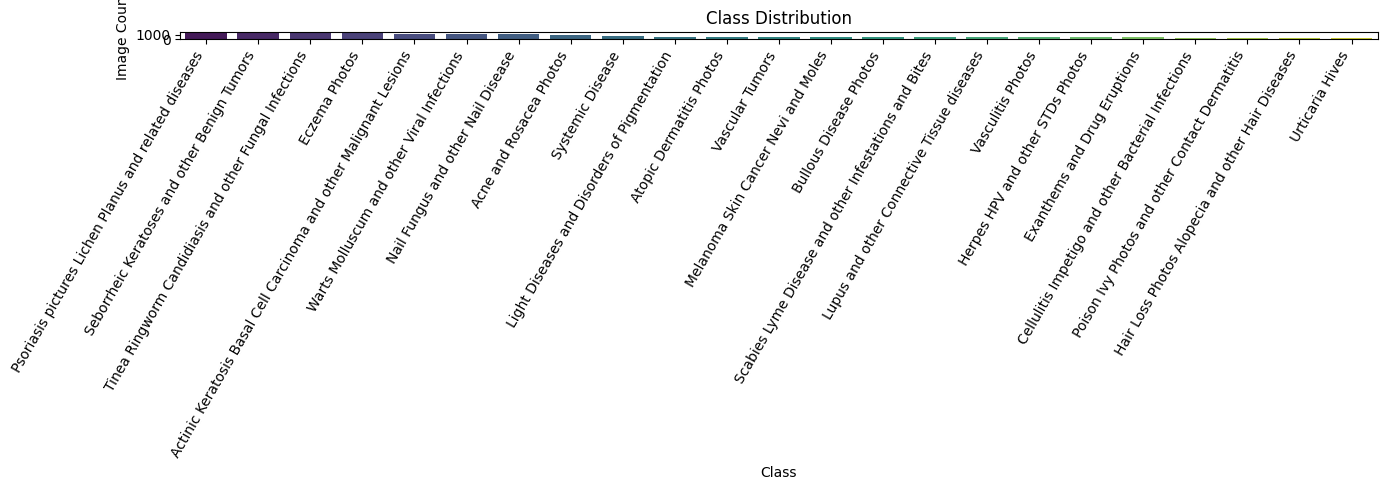

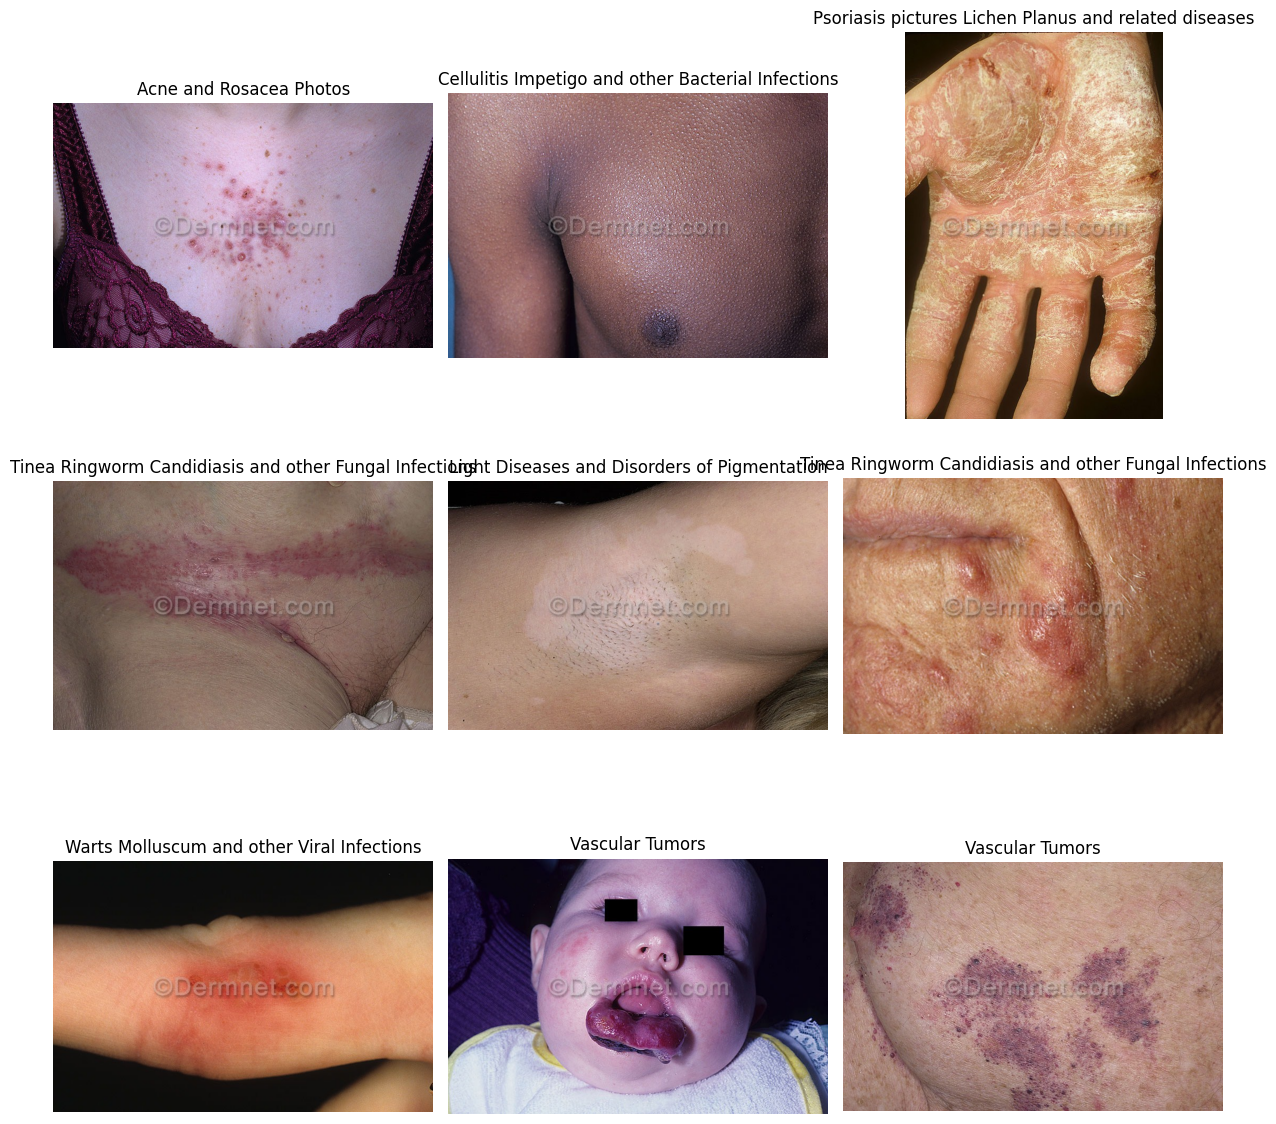

Train size: 12445 | Validation size: 3112
Train batch shape: (32, 3, 224, 224)
Train label range: [0, 22]


In [8]:
dataset_root = discover_dataset_root("/kaggle/input/datasets/shubhamgoel27/dermnet")
print(f"Dataset root: {dataset_root}")

df = build_dataframe_from_folder(dataset_root)
class_distribution = analyze_and_plot(df)
show_random_samples(df, n=9)

class_names = sorted(df["label"].unique().tolist())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}
num_classes = len(class_names)

train_df, val_df = stratified_split(df, val_size=0.2, seed=CONFIG["seed"])
print(f"Train size: {len(train_df)} | Validation size: {len(val_df)}")

train_loader, val_loader = get_dataloaders(
    train_df=train_df,
    val_df=val_df,
    class_to_idx=class_to_idx,
    batch_size=CONFIG["batch_size"],
    num_workers=CONFIG["num_workers"],
    use_weighted_sampler=CONFIG["use_weighted_sampler"],
)

first_images, first_labels = next(iter(train_loader))
print(f"Train batch shape: {tuple(first_images.shape)}")
print(f"Train label range: [{int(first_labels.min())}, {int(first_labels.max())}]")


In [9]:
model = create_model(num_classes=num_classes, freeze_backbone=True).to(device)

with torch.inference_mode():
    sample_inputs = first_images[:2].to(device)
    with autocast_context(device):
        sample_outputs = model(sample_inputs)
print(f"Sanity output shape: {tuple(sample_outputs.shape)}")

train_targets = train_df["label"].map(class_to_idx).to_numpy(dtype=np.int64)
class_weights = compute_class_weights(train_targets, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=CONFIG["label_smoothing"])

scaler = create_grad_scaler(device)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "lr": [],
}

best_model_path = Path(CONFIG["best_model_path"])
best_model_path.parent.mkdir(parents=True, exist_ok=True)

best_val_acc = 0.0
best_epoch = 0

total_epochs = CONFIG["head_epochs"] + CONFIG["finetune_epochs"]


Sanity output shape: (2, 23)


In [10]:
# Stage 1: train classifier head only
head_optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"],
)
head_scheduler = CosineAnnealingLR(head_optimizer, T_max=max(1, CONFIG["head_epochs"]))

for epoch in range(CONFIG["head_epochs"]):
    train_metrics = train_one_epoch(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=head_optimizer,
        scaler=scaler,
        device=device,
        max_grad_norm=CONFIG["max_grad_norm"],
        mixup_cfg={"enabled": CONFIG["mixup_enabled"], "alpha": CONFIG["mixup_alpha"]},
    )

    val_metrics = validate_one_epoch(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device,
    )

    head_scheduler.step()

    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_acc"].append(val_metrics["accuracy"])
    history["lr"].append(head_optimizer.param_groups[0]["lr"])

    current_epoch = epoch + 1
    print(
        f"Epoch {current_epoch}/{total_epochs} | "
        f"train_loss={train_metrics['loss']:.4f} train_acc={train_metrics['accuracy']:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} val_acc={val_metrics['accuracy']:.4f} "
        f"val_precision={val_metrics['precision']:.4f} val_recall={val_metrics['recall']:.4f} val_f1={val_metrics['f1']:.4f}"
    )

    if val_metrics["accuracy"] > best_val_acc:
        best_val_acc = val_metrics["accuracy"]
        best_epoch = current_epoch
        torch.save(model.state_dict(), best_model_path)

# Stage 2: unfreeze and fine-tune full network
unfreeze_model(model)

ft_optimizer = AdamW(
    model.parameters(),
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"],
)
ft_scheduler = CosineAnnealingLR(ft_optimizer, T_max=max(1, CONFIG["finetune_epochs"]))

patience_counter = 0
for epoch in range(CONFIG["finetune_epochs"]):
    train_metrics = train_one_epoch(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=ft_optimizer,
        scaler=scaler,
        device=device,
        max_grad_norm=CONFIG["max_grad_norm"],
        mixup_cfg={"enabled": CONFIG["mixup_enabled"], "alpha": CONFIG["mixup_alpha"]},
    )

    val_metrics = validate_one_epoch(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device,
    )

    ft_scheduler.step()

    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_acc"].append(val_metrics["accuracy"])
    history["lr"].append(ft_optimizer.param_groups[0]["lr"])

    current_epoch = CONFIG["head_epochs"] + epoch + 1
    print(
        f"Epoch {current_epoch}/{total_epochs} | "
        f"train_loss={train_metrics['loss']:.4f} train_acc={train_metrics['accuracy']:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} val_acc={val_metrics['accuracy']:.4f} "
        f"val_precision={val_metrics['precision']:.4f} val_recall={val_metrics['recall']:.4f} val_f1={val_metrics['f1']:.4f}"
    )

    if val_metrics["accuracy"] > best_val_acc:
        best_val_acc = val_metrics["accuracy"]
        best_epoch = current_epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= CONFIG["patience"]:
        print("Early stopping triggered.")
        break

print(f"Best validation accuracy during training: {best_val_acc * 100:.2f}% at epoch {best_epoch}")
print(f"Best model checkpoint: {best_model_path}")


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1/30 | train_loss=3.1421 train_acc=0.1287 | val_loss=3.0219 val_acc=0.1864 val_precision=0.1924 val_recall=0.1813 val_f1=0.1255


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/30 | train_loss=2.9560 train_acc=0.2192 | val_loss=2.9185 val_acc=0.2182 val_precision=0.2267 val_recall=0.2207 val_f1=0.1562


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3/30 | train_loss=2.8759 train_acc=0.2399 | val_loss=2.8665 val_acc=0.2497 val_precision=0.2514 val_recall=0.2398 val_f1=0.1901


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4/30 | train_loss=2.8336 train_acc=0.2543 | val_loss=2.8406 val_acc=0.2436 val_precision=0.2460 val_recall=0.2414 val_f1=0.1974


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5/30 | train_loss=2.8188 train_acc=0.2610 | val_loss=2.8389 val_acc=0.2455 val_precision=0.2378 val_recall=0.2435 val_f1=0.1937


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6/30 | train_loss=2.6563 train_acc=0.3082 | val_loss=2.5501 val_acc=0.3541 val_precision=0.3434 val_recall=0.3566 val_f1=0.3181


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7/30 | train_loss=2.3430 train_acc=0.4035 | val_loss=2.4912 val_acc=0.3985 val_precision=0.4081 val_recall=0.3991 val_f1=0.3713


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8/30 | train_loss=2.1208 train_acc=0.4693 | val_loss=2.4008 val_acc=0.3914 val_precision=0.4021 val_recall=0.4132 val_f1=0.3725


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9/30 | train_loss=1.9484 train_acc=0.5323 | val_loss=2.3883 val_acc=0.4229 val_precision=0.4244 val_recall=0.4434 val_f1=0.3989


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10/30 | train_loss=1.7892 train_acc=0.5874 | val_loss=2.3664 val_acc=0.4557 val_precision=0.4543 val_recall=0.4544 val_f1=0.4292


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11/30 | train_loss=1.6261 train_acc=0.6469 | val_loss=2.3567 val_acc=0.4557 val_precision=0.4562 val_recall=0.4748 val_f1=0.4373


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12/30 | train_loss=1.5086 train_acc=0.6930 | val_loss=2.3450 val_acc=0.4798 val_precision=0.4695 val_recall=0.4836 val_f1=0.4533


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13/30 | train_loss=1.3904 train_acc=0.7470 | val_loss=2.3423 val_acc=0.4865 val_precision=0.4840 val_recall=0.4821 val_f1=0.4599


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14/30 | train_loss=1.3164 train_acc=0.7782 | val_loss=2.2717 val_acc=0.4923 val_precision=0.4701 val_recall=0.4936 val_f1=0.4678


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15/30 | train_loss=1.2342 train_acc=0.8119 | val_loss=2.2980 val_acc=0.5183 val_precision=0.5107 val_recall=0.4933 val_f1=0.4880


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16/30 | train_loss=1.1691 train_acc=0.8421 | val_loss=2.2901 val_acc=0.5183 val_precision=0.4995 val_recall=0.5021 val_f1=0.4897


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17/30 | train_loss=1.1167 train_acc=0.8753 | val_loss=2.2511 val_acc=0.5231 val_precision=0.5039 val_recall=0.5134 val_f1=0.4959


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18/30 | train_loss=1.0677 train_acc=0.9004 | val_loss=2.2559 val_acc=0.5389 val_precision=0.5089 val_recall=0.5175 val_f1=0.5032


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19/30 | train_loss=1.0267 train_acc=0.9204 | val_loss=2.2454 val_acc=0.5263 val_precision=0.5079 val_recall=0.5115 val_f1=0.4937


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20/30 | train_loss=0.9962 train_acc=0.9324 | val_loss=2.1960 val_acc=0.5482 val_precision=0.5166 val_recall=0.5176 val_f1=0.5099


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21/30 | train_loss=0.9711 train_acc=0.9456 | val_loss=2.1432 val_acc=0.5701 val_precision=0.5331 val_recall=0.5403 val_f1=0.5304


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22/30 | train_loss=0.9510 train_acc=0.9535 | val_loss=2.1077 val_acc=0.5697 val_precision=0.5377 val_recall=0.5475 val_f1=0.5333


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23/30 | train_loss=0.9329 train_acc=0.9621 | val_loss=2.1241 val_acc=0.5774 val_precision=0.5488 val_recall=0.5459 val_f1=0.5383


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24/30 | train_loss=0.9186 train_acc=0.9671 | val_loss=2.1032 val_acc=0.5755 val_precision=0.5390 val_recall=0.5445 val_f1=0.5361


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25/30 | train_loss=0.9042 train_acc=0.9705 | val_loss=2.0844 val_acc=0.5832 val_precision=0.5457 val_recall=0.5584 val_f1=0.5453


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26/30 | train_loss=0.8954 train_acc=0.9720 | val_loss=2.0936 val_acc=0.5832 val_precision=0.5579 val_recall=0.5444 val_f1=0.5423


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27/30 | train_loss=0.8900 train_acc=0.9748 | val_loss=2.0758 val_acc=0.5877 val_precision=0.5593 val_recall=0.5604 val_f1=0.5511


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28/30 | train_loss=0.8842 train_acc=0.9773 | val_loss=2.0717 val_acc=0.5852 val_precision=0.5556 val_recall=0.5585 val_f1=0.5500


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29/30 | train_loss=0.8841 train_acc=0.9757 | val_loss=2.0716 val_acc=0.5839 val_precision=0.5500 val_recall=0.5521 val_f1=0.5445


Train:   0%|          | 0/389 [00:00<?, ?it/s]

Valid:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30/30 | train_loss=0.8794 train_acc=0.9774 | val_loss=2.0633 val_acc=0.5893 val_precision=0.5523 val_recall=0.5603 val_f1=0.5516
Best validation accuracy during training: 58.93% at epoch 30
Best model checkpoint: /kaggle/working/dermnet_resnet50_best.pth


Valid:   0%|          | 0/98 [00:00<?, ?it/s]

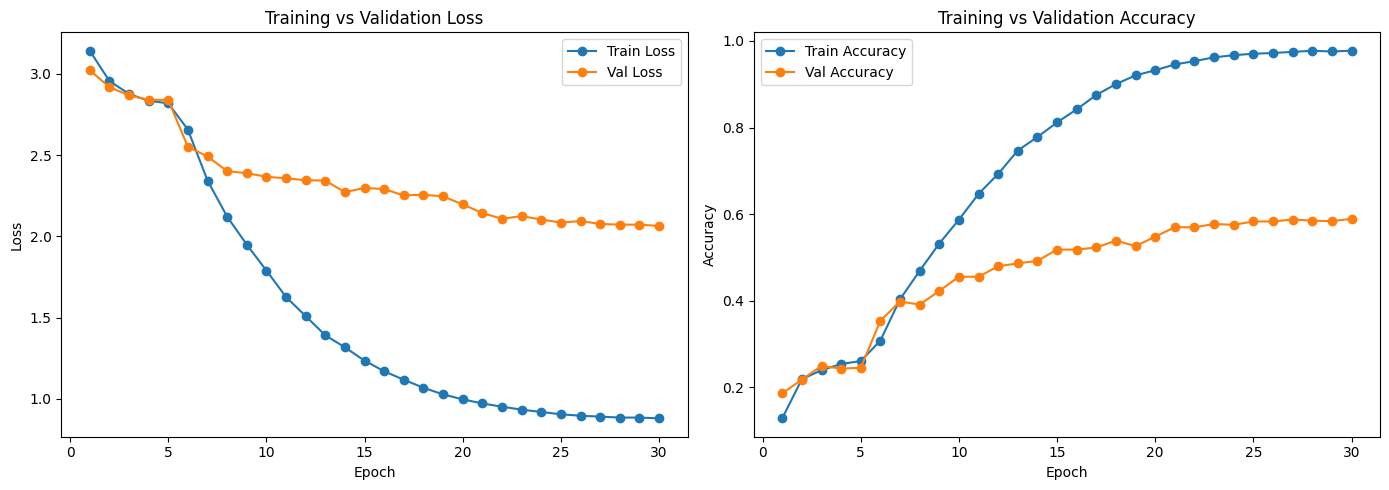

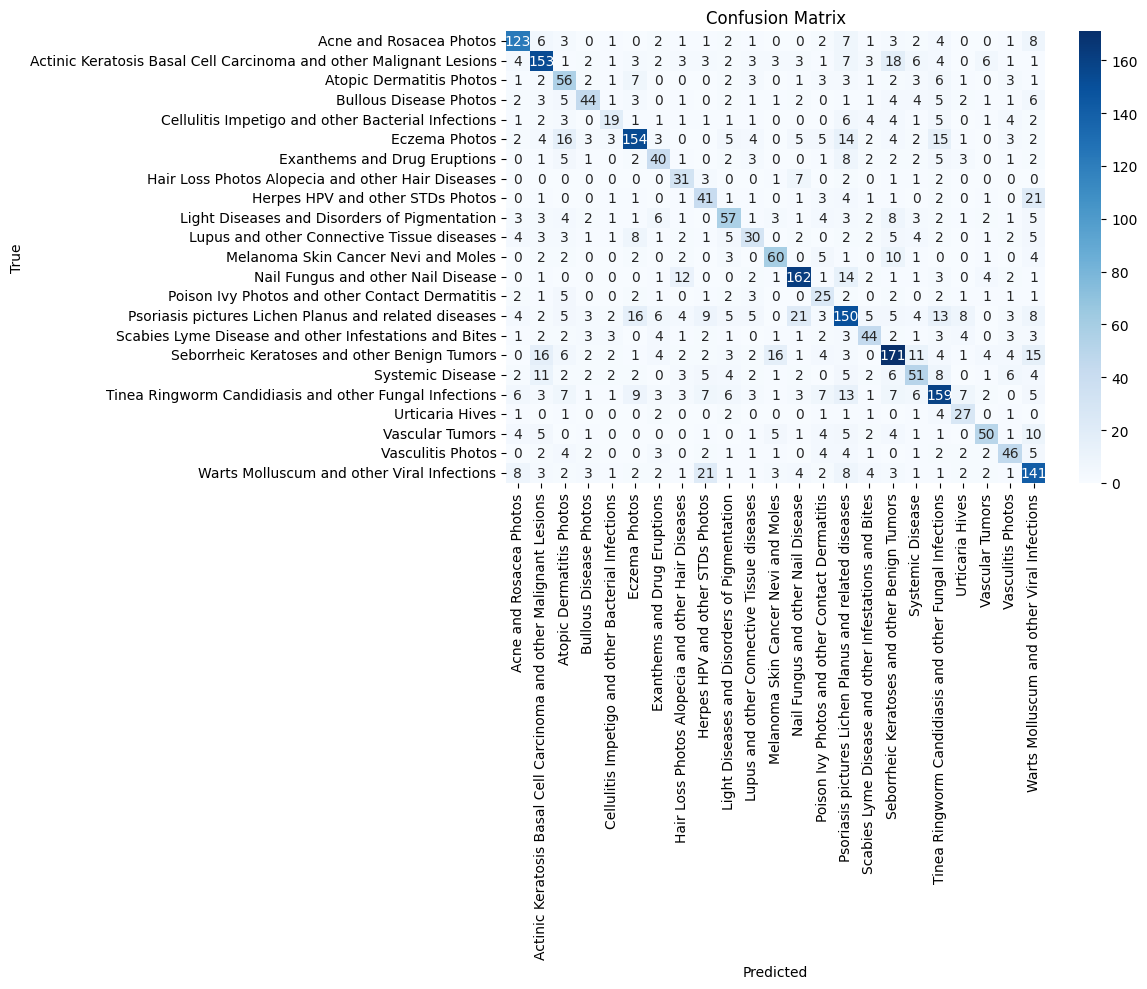

Validation Accuracy (standard): 58.93%
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.7321    0.7321    0.7321       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6770    0.6652    0.6711       230
                                          Atopic Dermatitis Photos     0.4242    0.5714    0.4870        98
                                            Bullous Disease Photos     0.6111    0.4889    0.5432        90
                Cellulitis Impetigo and other Bacterial Infections     0.4750    0.3276    0.3878        58
                                                     Eczema Photos     0.7196    0.6235    0.6681       247
                                      Exanthems and Drug Eruptions     0.4938    0.4938    0.4938        81
                 Hair Loss Photos Alopecia and other Hair Diseases     0.4429    0.6458    0.525

TTA:   0%|          | 0/3112 [00:00<?, ?it/s]

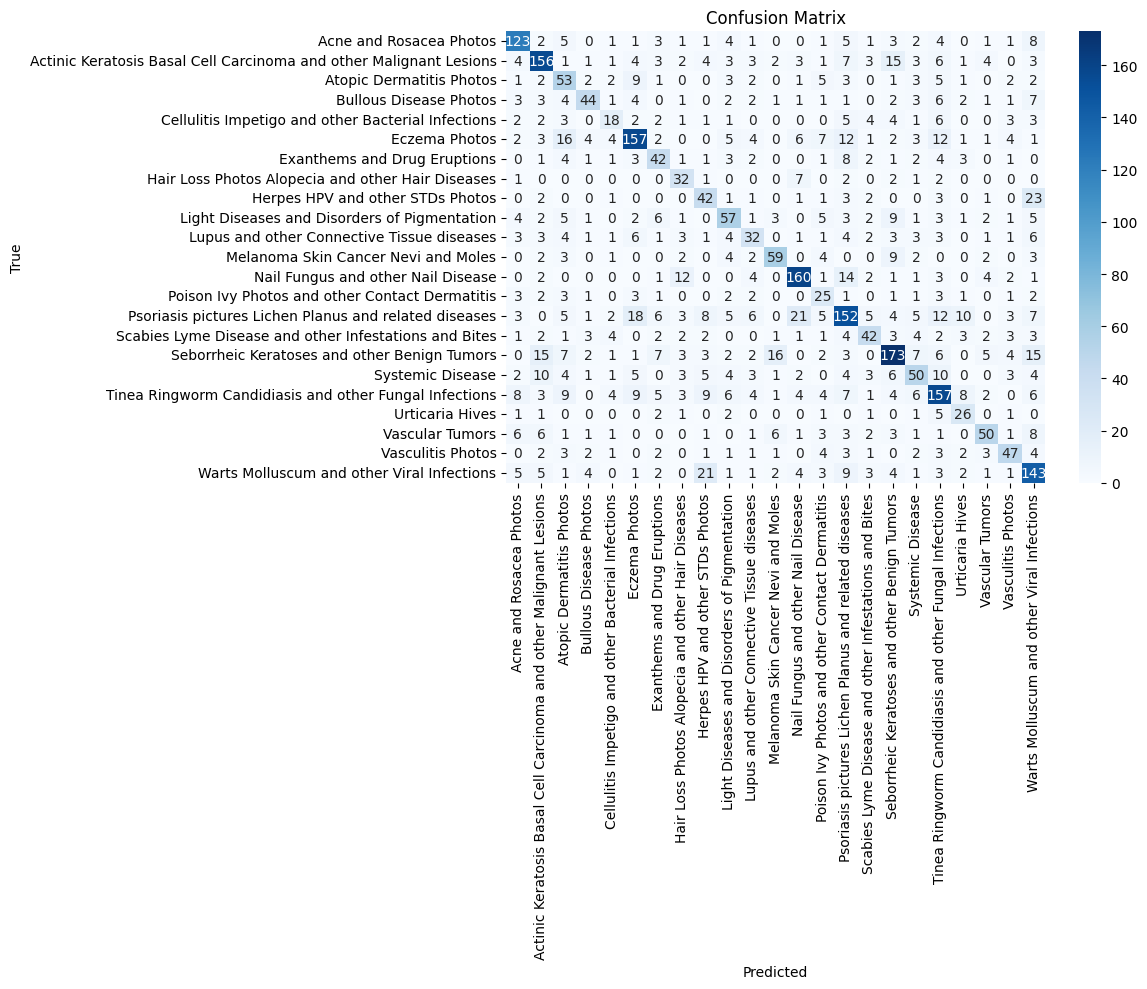

Final validation accuracy: 59.13%
TTA Precision (macro): 0.5514
TTA Recall (macro): 0.5608
TTA F1 (macro): 0.5516
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.7151    0.7321    0.7235       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6903    0.6783    0.6842       230
                                          Atopic Dermatitis Photos     0.4015    0.5408    0.4609        98
                                            Bullous Disease Photos     0.6377    0.4889    0.5535        90
                Cellulitis Impetigo and other Bacterial Infections     0.4000    0.3103    0.3495        58
                                                     Eczema Photos     0.6978    0.6356    0.6653       247
                                      Exanthems and Drug Eruptions     0.4773    0.5185    0.4970        81
                 Hair

In [11]:
model.load_state_dict(torch.load(best_model_path, map_location=device))

final_val_metrics = validate_one_epoch(
    model=model,
    loader=val_loader,
    criterion=criterion,
    device=device,
)

labels_idx = list(range(num_classes))
standard_cm = confusion_matrix(final_val_metrics["y_true"], final_val_metrics["y_pred"], labels=labels_idx)

plot_history(history)
plot_confusion(standard_cm, class_names)

print(f"Validation Accuracy (standard): {final_val_metrics['accuracy'] * 100:.2f}%")
print(
    classification_report(
        final_val_metrics["y_true"],
        final_val_metrics["y_pred"],
        labels=labels_idx,
        target_names=class_names,
        digits=4,
        zero_division=0,
    )
)

tta_true, tta_pred = predict_with_tta(
    model=model,
    loader=val_loader,
    device=device,
    num_classes=num_classes,
    tta_steps=CONFIG["tta_steps"],
)

tta_acc = accuracy_score(tta_true, tta_pred)
tta_precision, tta_recall, tta_f1, _ = precision_recall_fscore_support(
    tta_true,
    tta_pred,
    average="macro",
    zero_division=0,
)

tta_cm = confusion_matrix(tta_true, tta_pred, labels=labels_idx)
plot_confusion(tta_cm, class_names)

print(f"Final validation accuracy: {tta_acc * 100:.2f}%")
print(f"TTA Precision (macro): {tta_precision:.4f}")
print(f"TTA Recall (macro): {tta_recall:.4f}")
print(f"TTA F1 (macro): {tta_f1:.4f}")
print(
    classification_report(
        tta_true,
        tta_pred,
        labels=labels_idx,
        target_names=class_names,
        digits=4,
        zero_division=0,
    )
)

print(f"Saved best model: {best_model_path}")


In [12]:
from torchvision.transforms import InterpolationMode

ADV_CONFIG = {
    "seed": 1337,
    "img_size": 320,
    "batch_size": 24,
    "num_workers": 4,
    "head_epochs": 4,
    "layer4_epochs": 6,
    "full_epochs": 24,
    "head_lr": 3e-4,
    "layer4_lr": 1.5e-4,
    "full_lr": 6e-5,
    "min_lr": 1e-6,
    "weight_decay": 2e-4,
    "label_smoothing": 0.05,
    "mixup_enabled": True,
    "mixup_alpha": 0.2,
    "mixup_prob": 0.35,
    "grad_clip": 1.0,
    "patience": 10,
    "use_weighted_sampler": True,
    "ema_decay": 0.9995,
    "tta_steps": 8,
    "best_model_path": "/kaggle/working/dermnet_resnet50_best_advanced.pth",
}

GENERIC_DIR_NAMES = {
    "train", "training", "val", "valid", "validation", "test", "testing",
    "images", "imgs", "data", "dataset"
}


def _candidate_roots(input_root: Path, max_depth: int = 4):
    roots = []
    frontier = [input_root]
    for _ in range(max_depth):
        new_frontier = []
        for parent in frontier:
            try:
                children = [d for d in parent.iterdir() if d.is_dir()]
            except Exception:
                continue
            roots.extend(children)
            new_frontier.extend(children)
        frontier = new_frontier
    return roots


def _count_images_fast(folder: Path) -> int:
    return sum(1 for f in folder.rglob("*") if f.is_file() and f.suffix.lower() in IMG_EXTENSIONS)


def find_dermnet_training_root(input_root: str = "/kaggle/input") -> Path:
    input_root = Path(input_root)
    if not input_root.exists():
        raise FileNotFoundError(f"Input root not found: {input_root}")

    candidates = []
    for p in _candidate_roots(input_root, max_depth=4):
        try:
            class_dirs = [d for d in p.iterdir() if d.is_dir()]
        except Exception:
            continue

        if len(class_dirs) < 2:
            continue

        class_counts = []
        generic_count = 0

        for d in class_dirs:
            c = _count_images_fast(d)
            if c > 0:
                class_counts.append(c)
                if d.name.lower() in GENERIC_DIR_NAMES:
                    generic_count += 1

        if len(class_counts) < 2:
            continue

        non_generic = len(class_counts) - generic_count
        score = (non_generic, len(class_counts), int(np.sum(class_counts)), -generic_count)
        candidates.append((score, p))

    if not candidates:
        raise RuntimeError("Could not find a valid DermNet training root under /kaggle/input")

    return sorted(candidates, key=lambda x: x[0], reverse=True)[0][1]


def build_strong_transforms(image_size: int = 320):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(
            image_size,
            scale=(0.65, 1.0),
            ratio=(0.75, 1.3333),
            interpolation=InterpolationMode.BICUBIC,
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.15),
        transforms.RandomRotation(25, interpolation=InterpolationMode.BILINEAR),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2, hue=0.03)],
            p=0.7,
        ),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3), value="random"),
    ])

    val_transform = transforms.Compose([
        transforms.Resize(int(image_size * 1.15), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    return train_transform, val_transform


def get_strong_dataloaders(train_df, val_df, class_to_idx, cfg):
    train_tfm, val_tfm = build_strong_transforms(cfg["img_size"])

    train_ds = DermNetDataset(train_df, class_to_idx, transform=train_tfm)
    val_ds = DermNetDataset(val_df, class_to_idx, transform=val_tfm)

    sampler = None
    if cfg["use_weighted_sampler"]:
        targets = train_ds.labels
        class_counts = np.bincount(targets, minlength=len(class_to_idx)).astype(np.float64)
        class_weights = np.zeros_like(class_counts, dtype=np.float64)
        nonzero = class_counts > 0
        class_weights[nonzero] = 1.0 / np.sqrt(class_counts[nonzero])
        sample_weights = class_weights[targets]
        sampler = WeightedRandomSampler(
            weights=torch.as_tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )

    pin = device.type == "cuda"

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg["batch_size"],
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=cfg["num_workers"],
        pin_memory=pin,
        persistent_workers=(cfg["num_workers"] > 0),
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=cfg["batch_size"],
        shuffle=False,
        num_workers=cfg["num_workers"],
        pin_memory=pin,
        persistent_workers=(cfg["num_workers"] > 0),
    )

    return train_loader, val_loader


set_seed(ADV_CONFIG["seed"])
adv_root = find_dermnet_training_root("/kaggle/input")
print(f"Advanced root: {adv_root}")

df_adv = build_dataframe_from_folder(adv_root)
print(f"Advanced total images: {len(df_adv)} | classes: {df_adv['label'].nunique()}")

class_names_adv = sorted(df_adv["label"].unique().tolist())
class_to_idx_adv = {name: idx for idx, name in enumerate(class_names_adv)}
idx_to_class_adv = {idx: name for name, idx in class_to_idx_adv.items()}
num_classes_adv = len(class_names_adv)

train_df_adv, val_df_adv = stratified_split(df_adv, val_size=0.2, seed=ADV_CONFIG["seed"])
print(f"Advanced split -> train: {len(train_df_adv)} | val: {len(val_df_adv)}")

train_loader_adv, val_loader_adv = get_strong_dataloaders(
    train_df=train_df_adv,
    val_df=val_df_adv,
    class_to_idx=class_to_idx_adv,
    cfg=ADV_CONFIG,
)

x_adv, y_adv = next(iter(train_loader_adv))
print(f"Advanced train batch shape: {tuple(x_adv.shape)}")
print(f"Advanced label range: [{int(y_adv.min())}, {int(y_adv.max())}]")


Advanced root: /kaggle/input/datasets/shubhamgoel27/dermnet/train
Advanced total images: 15557 | classes: 23
Advanced split -> train: 12445 | val: 3112
Advanced train batch shape: (24, 3, 320, 320)
Advanced label range: [1, 22]


In [13]:
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995):
        self.ema = copy.deepcopy(model).eval()
        self.decay = decay
        for p in self.ema.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, model: nn.Module):
        msd = model.state_dict()
        for k, v in self.ema.state_dict().items():
            src = msd[k].detach()
            if v.dtype.is_floating_point:
                v.mul_(self.decay).add_(src, alpha=1.0 - self.decay)
            else:
                v.copy_(src)


def create_resnet50_high_acc(num_classes: int, dropout: float = 0.35) -> nn.Module:
    try:
        model = models.resnet50(weights="IMAGENET1K_V2")
    except Exception:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes),
    )
    return model


def set_trainable_stage(model: nn.Module, stage: str):
    for p in model.parameters():
        p.requires_grad = False

    if stage == "head":
        for p in model.fc.parameters():
            p.requires_grad = True
    elif stage == "layer4_head":
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True
    elif stage == "full":
        for p in model.parameters():
            p.requires_grad = True
    else:
        raise ValueError(f"Unknown stage: {stage}")


def build_stage_optimizer(model: nn.Module, stage: str, cfg: dict):
    wd = cfg["weight_decay"]

    if stage == "head":
        return AdamW(model.fc.parameters(), lr=cfg["head_lr"], weight_decay=wd)

    if stage == "layer4_head":
        return AdamW([
            {"params": model.layer4.parameters(), "lr": cfg["layer4_lr"]},
            {"params": model.fc.parameters(), "lr": cfg["head_lr"]},
        ], weight_decay=wd)

    if stage == "full":
        return AdamW([
            {"params": model.conv1.parameters(), "lr": cfg["full_lr"] * 0.20},
            {"params": model.bn1.parameters(), "lr": cfg["full_lr"] * 0.20},
            {"params": model.layer1.parameters(), "lr": cfg["full_lr"] * 0.35},
            {"params": model.layer2.parameters(), "lr": cfg["full_lr"] * 0.55},
            {"params": model.layer3.parameters(), "lr": cfg["full_lr"] * 0.80},
            {"params": model.layer4.parameters(), "lr": cfg["full_lr"]},
            {"params": model.fc.parameters(), "lr": cfg["full_lr"] * 1.8},
        ], weight_decay=wd)

    raise ValueError(f"Unknown stage: {stage}")


def create_scaler(device: torch.device):
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            return torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))
        except TypeError:
            return torch.amp.GradScaler(enabled=(device.type == "cuda"))
    return torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


def amp_autocast(device: torch.device):
    if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
        return torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda"))
    return torch.cuda.amp.autocast(enabled=(device.type == "cuda"))


def train_one_epoch_adv(
    model,
    loader,
    criterion,
    optimizer,
    scaler,
    device,
    grad_clip,
    mixup_enabled,
    mixup_alpha,
    mixup_prob,
    ema=None,
):
    model.train()
    total = 0
    running_loss = 0.0
    running_correct = 0.0

    pbar = tqdm(loader, desc="Train+", leave=False)
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        apply_mixup = mixup_enabled and (np.random.rand() < mixup_prob)
        if apply_mixup:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

        with amp_autocast(device):
            logits = model(images)
            if apply_mixup:
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        if ema is not None:
            ema.update(model)

        bs = labels.size(0)
        total += bs
        running_loss += loss.item() * bs

        preds = logits.argmax(dim=1)
        if apply_mixup:
            correct = lam * preds.eq(y_a).sum().item() + (1.0 - lam) * preds.eq(y_b).sum().item()
        else:
            correct = preds.eq(labels).sum().item()
        running_correct += correct

        pbar.set_postfix(loss=running_loss / total, acc=running_correct / total)

    return {
        "loss": running_loss / total,
        "accuracy": running_correct / total,
    }


def validate_one_epoch_adv(model, loader, criterion, device):
    model.eval()
    total = 0
    running_loss = 0.0
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc="Valid+", leave=False)
    with torch.inference_mode():
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with amp_autocast(device):
                logits = model(images)
                loss = criterion(logits, labels)

            bs = labels.size(0)
            total += bs
            running_loss += loss.item() * bs

            preds = logits.argmax(dim=1)
            y_true.append(labels.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

            pbar.set_postfix(loss=running_loss / total)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }


def predict_with_tta_adv(model, dataset, device, num_classes: int, img_size: int, tta_steps: int = 8):
    model.eval()

    tta_bank = [
        transforms.Compose([
            transforms.Resize(int(img_size * 1.15), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.15), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.20), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.10), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.15), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.RandomRotation((8, 8), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.15), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.RandomRotation((-8, -8), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.15), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(int(img_size * 1.25), interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
    ]

    tta_bank = tta_bank[:max(1, min(tta_steps, len(tta_bank)))]

    y_true, y_pred = [], []
    with torch.inference_mode():
        for p, y in tqdm(zip(dataset.paths, dataset.labels), total=len(dataset), desc="TTA+", leave=False):
            img = Image.open(p).convert("RGB")
            avg_prob = torch.zeros(num_classes, device=device)

            for tfm in tta_bank:
                x = tfm(img).unsqueeze(0).to(device, non_blocking=True)
                with amp_autocast(device):
                    logits = model(x)
                avg_prob += torch.softmax(logits, dim=1).squeeze(0)

            pred = torch.argmax(avg_prob / len(tta_bank)).item()
            y_true.append(int(y))
            y_pred.append(pred)

    return np.array(y_true), np.array(y_pred)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 1/34 stage=head train_loss=2.8746 train_acc=0.1821 val_loss=3.0863 val_acc=0.0765 val_f1=0.0460


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 2/34 stage=head train_loss=2.6482 train_acc=0.2599 val_loss=2.9585 val_acc=0.1954 val_f1=0.1364


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 3/34 stage=head train_loss=2.5596 train_acc=0.2824 val_loss=2.8319 val_acc=0.2558 val_f1=0.1856


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 4/34 stage=head train_loss=2.5324 train_acc=0.2902 val_loss=2.7274 val_acc=0.2915 val_f1=0.2175


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 5/34 stage=layer4_head train_loss=2.3034 train_acc=0.3526 val_loss=2.5781 val_acc=0.3207 val_f1=0.2471


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 6/34 stage=layer4_head train_loss=2.0044 train_acc=0.4519 val_loss=2.4080 val_acc=0.3583 val_f1=0.2854


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 7/34 stage=layer4_head train_loss=1.8169 train_acc=0.5155 val_loss=2.2502 val_acc=0.3907 val_f1=0.3213


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 8/34 stage=layer4_head train_loss=1.6104 train_acc=0.5827 val_loss=2.1131 val_acc=0.4267 val_f1=0.3632


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 9/34 stage=layer4_head train_loss=1.5094 train_acc=0.6170 val_loss=1.9970 val_acc=0.4531 val_f1=0.3970


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 10/34 stage=layer4_head train_loss=1.4375 train_acc=0.6456 val_loss=1.9086 val_acc=0.4798 val_f1=0.4282


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 11/34 stage=full train_loss=1.4349 train_acc=0.6489 val_loss=1.8410 val_acc=0.5013 val_f1=0.4523


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 12/34 stage=full train_loss=1.3069 train_acc=0.6891 val_loss=1.7835 val_acc=0.5228 val_f1=0.4795


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 13/34 stage=full train_loss=1.2208 train_acc=0.7254 val_loss=1.7381 val_acc=0.5382 val_f1=0.4997


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 14/34 stage=full train_loss=1.1712 train_acc=0.7446 val_loss=1.7018 val_acc=0.5508 val_f1=0.5130


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 15/34 stage=full train_loss=1.1023 train_acc=0.7643 val_loss=1.6720 val_acc=0.5627 val_f1=0.5250


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 16/34 stage=full train_loss=1.0129 train_acc=0.8013 val_loss=1.6556 val_acc=0.5746 val_f1=0.5361


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 17/34 stage=full train_loss=1.0156 train_acc=0.8001 val_loss=1.6417 val_acc=0.5813 val_f1=0.5433


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 18/34 stage=full train_loss=0.9286 train_acc=0.8323 val_loss=1.6303 val_acc=0.5903 val_f1=0.5502


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 19/34 stage=full train_loss=0.8939 train_acc=0.8467 val_loss=1.6243 val_acc=0.5964 val_f1=0.5584


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 20/34 stage=full train_loss=0.8754 train_acc=0.8516 val_loss=1.6194 val_acc=0.6003 val_f1=0.5644


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 21/34 stage=full train_loss=0.8479 train_acc=0.8592 val_loss=1.6177 val_acc=0.6073 val_f1=0.5744


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 22/34 stage=full train_loss=0.8501 train_acc=0.8636 val_loss=1.6180 val_acc=0.6160 val_f1=0.5828


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 23/34 stage=full train_loss=0.8133 train_acc=0.8732 val_loss=1.6209 val_acc=0.6199 val_f1=0.5832


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 24/34 stage=full train_loss=0.7837 train_acc=0.8847 val_loss=1.6211 val_acc=0.6195 val_f1=0.5823


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 25/34 stage=full train_loss=0.7733 train_acc=0.8883 val_loss=1.6214 val_acc=0.6170 val_f1=0.5794


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 26/34 stage=full train_loss=0.7709 train_acc=0.8918 val_loss=1.6220 val_acc=0.6189 val_f1=0.5813


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 27/34 stage=full train_loss=0.7645 train_acc=0.8935 val_loss=1.6210 val_acc=0.6211 val_f1=0.5829


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 28/34 stage=full train_loss=0.7508 train_acc=0.9011 val_loss=1.6206 val_acc=0.6208 val_f1=0.5840


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 29/34 stage=full train_loss=0.7175 train_acc=0.9099 val_loss=1.6223 val_acc=0.6211 val_f1=0.5846


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 30/34 stage=full train_loss=0.7274 train_acc=0.9071 val_loss=1.6232 val_acc=0.6215 val_f1=0.5861


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 31/34 stage=full train_loss=0.6927 train_acc=0.9135 val_loss=1.6252 val_acc=0.6183 val_f1=0.5827


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 32/34 stage=full train_loss=0.7031 train_acc=0.9142 val_loss=1.6250 val_acc=0.6186 val_f1=0.5832


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 33/34 stage=full train_loss=0.6963 train_acc=0.9148 val_loss=1.6245 val_acc=0.6192 val_f1=0.5832


Train+:   0%|          | 0/519 [00:00<?, ?it/s]

Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

[ADV] Epoch 34/34 stage=full train_loss=0.7090 train_acc=0.9120 val_loss=1.6240 val_acc=0.6192 val_f1=0.5823
[ADV] Best validation accuracy: 62.15% @ epoch 30
[ADV] Best checkpoint: /kaggle/working/dermnet_resnet50_best_advanced.pth


Valid+:   0%|          | 0/130 [00:00<?, ?it/s]

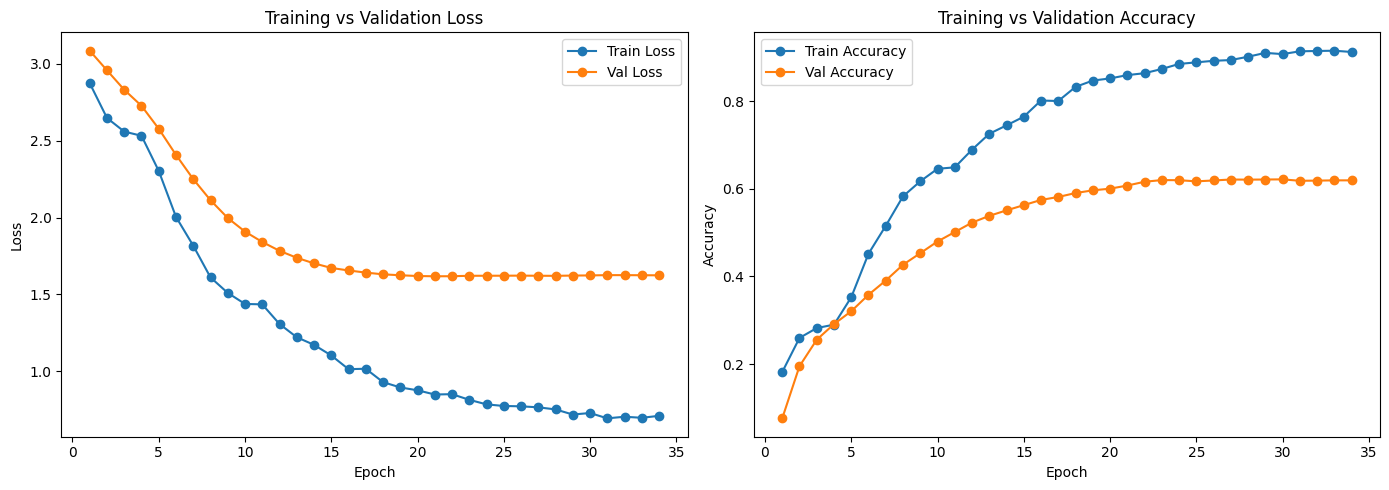

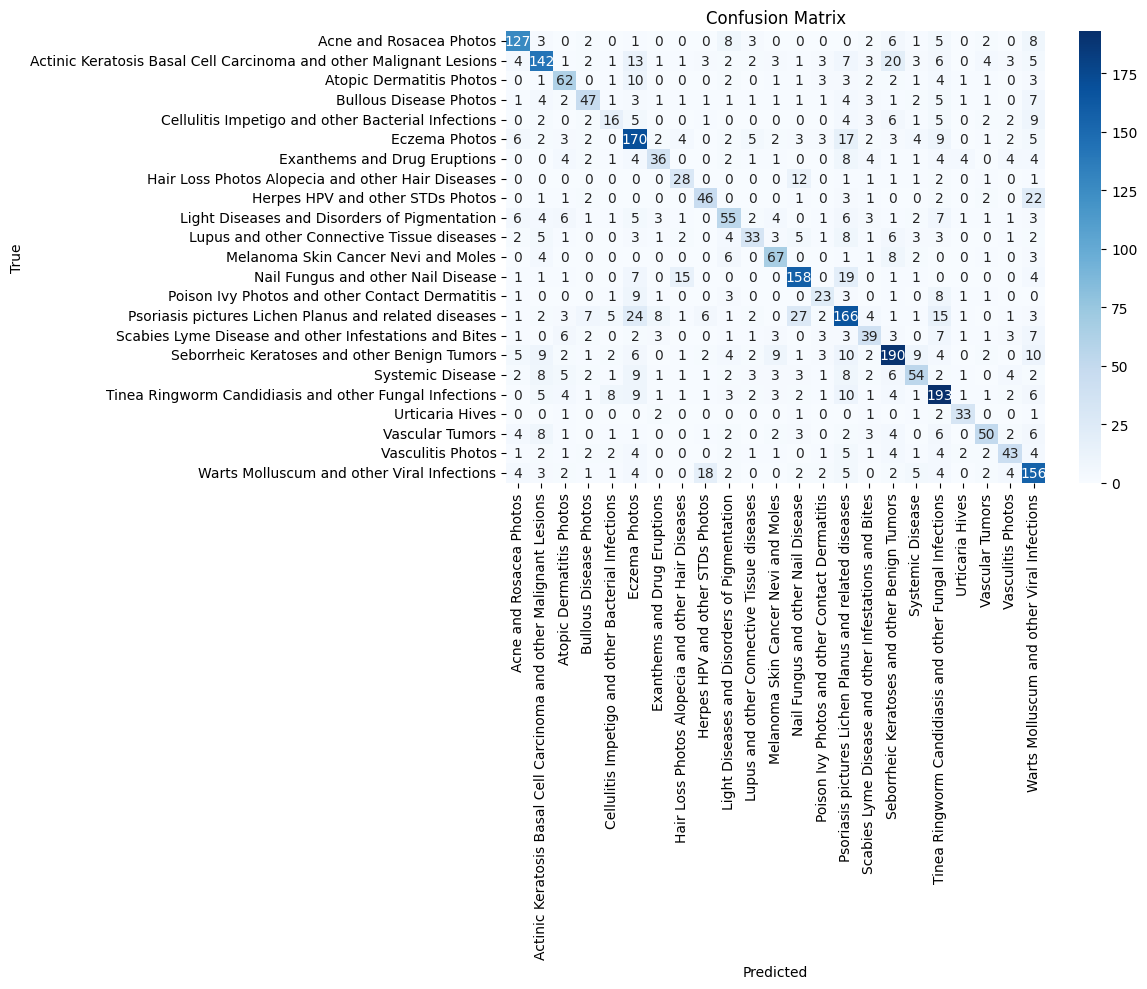

[ADV] Validation Accuracy (standard): 62.15%
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.7651    0.7560    0.7605       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6893    0.6174    0.6514       230
                                          Atopic Dermatitis Photos     0.5849    0.6327    0.6078        98
                                            Bullous Disease Photos     0.6184    0.5222    0.5663        90
                Cellulitis Impetigo and other Bacterial Infections     0.3810    0.2759    0.3200        58
                                                     Eczema Photos     0.5882    0.6883    0.6343       247
                                      Exanthems and Drug Eruptions     0.6000    0.4444    0.5106        81
                 Hair Loss Photos Alopecia and other Hair Diseases     0.5000    0.5833   

TTA+:   0%|          | 0/3112 [00:00<?, ?it/s]

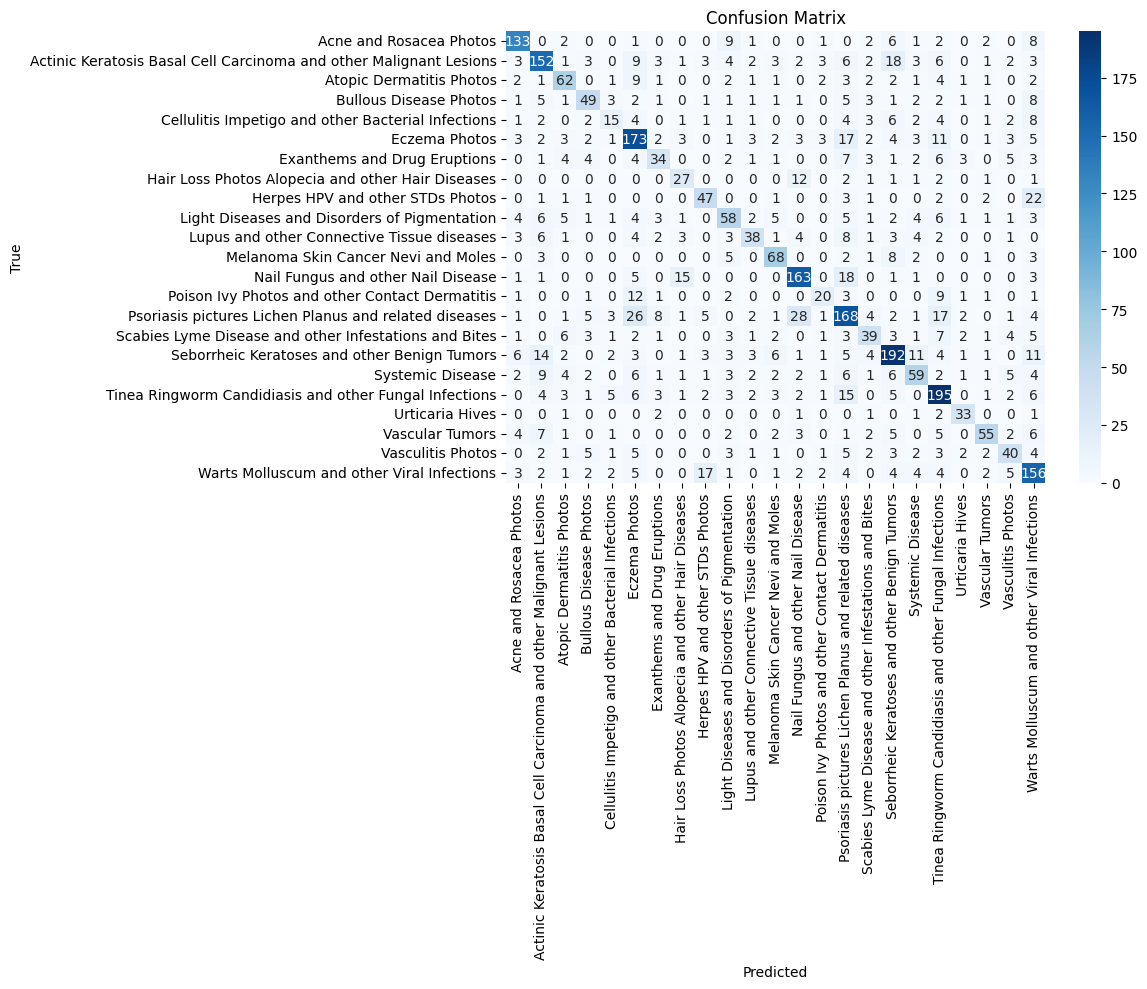

[ADV] Final validation accuracy (TTA): 63.50%
[ADV] TTA Precision (macro): 0.6109
[ADV] TTA Recall (macro): 0.5896
[ADV] TTA F1 (macro): 0.5962
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.7870    0.7917    0.7893       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6972    0.6609    0.6786       230
                                          Atopic Dermatitis Photos     0.6200    0.6327    0.6263        98
                                            Bullous Disease Photos     0.6049    0.5444    0.5731        90
                Cellulitis Impetigo and other Bacterial Infections     0.4167    0.2586    0.3191        58
                                                     Eczema Photos     0.6179    0.7004    0.6565       247
                                      Exanthems and Drug Eruptions     0.5484    0.4198    0.4755  

In [14]:
set_seed(ADV_CONFIG["seed"])

model_adv = create_resnet50_high_acc(num_classes_adv, dropout=0.35).to(device)
ema_adv = ModelEMA(model_adv, decay=ADV_CONFIG["ema_decay"])
scaler_adv = create_scaler(device)
criterion_adv = nn.CrossEntropyLoss(label_smoothing=ADV_CONFIG["label_smoothing"])

history_adv = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "val_f1": [],
    "lr": [],
}

stage_plan = [
    ("head", ADV_CONFIG["head_epochs"]),
    ("layer4_head", ADV_CONFIG["layer4_epochs"]),
    ("full", ADV_CONFIG["full_epochs"]),
]

total_adv_epochs = sum(epochs for _, epochs in stage_plan)
best_acc_adv = 0.0
best_epoch_adv = 0
patience_counter = 0
global_epoch = 0
stop_training = False

for stage_name, stage_epochs in stage_plan:
    set_trainable_stage(model_adv, stage_name)
    optimizer_adv = build_stage_optimizer(model_adv, stage_name, ADV_CONFIG)
    scheduler_adv = CosineAnnealingLR(
        optimizer_adv,
        T_max=max(1, stage_epochs),
        eta_min=ADV_CONFIG["min_lr"],
    )

    for _ in range(stage_epochs):
        global_epoch += 1

        tr = train_one_epoch_adv(
            model=model_adv,
            loader=train_loader_adv,
            criterion=criterion_adv,
            optimizer=optimizer_adv,
            scaler=scaler_adv,
            device=device,
            grad_clip=ADV_CONFIG["grad_clip"],
            mixup_enabled=(ADV_CONFIG["mixup_enabled"] and stage_name != "head"),
            mixup_alpha=ADV_CONFIG["mixup_alpha"],
            mixup_prob=ADV_CONFIG["mixup_prob"],
            ema=ema_adv,
        )

        scheduler_adv.step()

        eval_model = ema_adv.ema if ema_adv is not None else model_adv
        va = validate_one_epoch_adv(
            model=eval_model,
            loader=val_loader_adv,
            criterion=criterion_adv,
            device=device,
        )

        history_adv["train_loss"].append(tr["loss"])
        history_adv["val_loss"].append(va["loss"])
        history_adv["train_acc"].append(tr["accuracy"])
        history_adv["val_acc"].append(va["accuracy"])
        history_adv["val_f1"].append(va["f1"])
        history_adv["lr"].append(optimizer_adv.param_groups[-1]["lr"])

        print(
            f"[ADV] Epoch {global_epoch}/{total_adv_epochs} stage={stage_name} "
            f"train_loss={tr['loss']:.4f} train_acc={tr['accuracy']:.4f} "
            f"val_loss={va['loss']:.4f} val_acc={va['accuracy']:.4f} val_f1={va['f1']:.4f}"
        )

        if va["accuracy"] > best_acc_adv:
            best_acc_adv = va["accuracy"]
            best_epoch_adv = global_epoch
            patience_counter = 0
            torch.save(
                {
                    "model": model_adv.state_dict(),
                    "ema": ema_adv.ema.state_dict() if ema_adv is not None else None,
                    "best_acc": best_acc_adv,
                    "epoch": best_epoch_adv,
                    "class_to_idx": class_to_idx_adv,
                    "config": ADV_CONFIG,
                },
                ADV_CONFIG["best_model_path"],
            )
        else:
            patience_counter += 1

        if patience_counter >= ADV_CONFIG["patience"]:
            print("[ADV] Early stopping triggered.")
            stop_training = True
            break

    if stop_training:
        break

print(f"[ADV] Best validation accuracy: {best_acc_adv * 100:.2f}% @ epoch {best_epoch_adv}")
print(f"[ADV] Best checkpoint: {ADV_CONFIG['best_model_path']}")

adv_ckpt = torch.load(ADV_CONFIG["best_model_path"], map_location=device)

eval_model_adv = create_resnet50_high_acc(num_classes_adv, dropout=0.35).to(device)
if adv_ckpt.get("ema") is not None:
    eval_model_adv.load_state_dict(adv_ckpt["ema"])
else:
    eval_model_adv.load_state_dict(adv_ckpt["model"])

final_std = validate_one_epoch_adv(
    model=eval_model_adv,
    loader=val_loader_adv,
    criterion=criterion_adv,
    device=device,
)

cm_std = confusion_matrix(final_std["y_true"], final_std["y_pred"], labels=list(range(num_classes_adv)))
plot_history({
    "train_loss": history_adv["train_loss"],
    "val_loss": history_adv["val_loss"],
    "train_acc": history_adv["train_acc"],
    "val_acc": history_adv["val_acc"],
})
plot_confusion(cm_std, class_names_adv)

print(f"[ADV] Validation Accuracy (standard): {final_std['accuracy'] * 100:.2f}%")
print(
    classification_report(
        final_std["y_true"],
        final_std["y_pred"],
        labels=list(range(num_classes_adv)),
        target_names=class_names_adv,
        digits=4,
        zero_division=0,
    )
)

tta_true_adv, tta_pred_adv = predict_with_tta_adv(
    model=eval_model_adv,
    dataset=val_loader_adv.dataset,
    device=device,
    num_classes=num_classes_adv,
    img_size=ADV_CONFIG["img_size"],
    tta_steps=ADV_CONFIG["tta_steps"],
)

tta_acc_adv = accuracy_score(tta_true_adv, tta_pred_adv)
tta_p_adv, tta_r_adv, tta_f_adv, _ = precision_recall_fscore_support(
    tta_true_adv,
    tta_pred_adv,
    average="macro",cc=0.3526 val_loss=2.5781 val_acc=0.3207 val_f1=0.2471
[ADV] Epoch 6/34 stage=layer4_head train_loss=2.0044 train_acc=0.4519 val_l
    zero_division=0,
)

cm_tta = confusion_matrix(tta_true_adv, tta_pred_adv, labels=list(range(num_classes_adv)))
plot_confusion(cm_tta, class_names_adv)

print(f"[ADV] Final validation accuracy (TTA): {tta_acc_adv * 100:.2f}%")
print(f"[ADV] TTA Precision (macro): {tta_p_adv:.4f}")
print(f"[ADV] TTA Recall (macro): {tta_r_adv:.4f}")
print(f"[ADV] TTA F1 (macro): {tta_f_adv:.4f}")
print(
    classification_report(
        tta_true_adv,
        tta_pred_adv,
        labels=list(range(num_classes_adv)),
        target_names=class_names_adv,
        digits=4,
        zero_division=0,
    )
)

print(f"[ADV] Saved best model: {ADV_CONFIG['best_model_path']}")
